Epoch 1/25:
Train Loss: 1.8270, Train Acc: 33.01%
Test Acc: 42.70%
Epoch 2/25:
Train Loss: 1.5155, Train Acc: 45.17%
Test Acc: 46.50%
Epoch 3/25:
Train Loss: 1.4089, Train Acc: 49.42%
Test Acc: 49.98%
Epoch 4/25:
Train Loss: 1.3311, Train Acc: 52.10%
Test Acc: 51.65%
Epoch 5/25:
Train Loss: 1.2604, Train Acc: 54.64%
Test Acc: 53.49%
Epoch 6/25:
Train Loss: 1.2058, Train Acc: 57.02%
Test Acc: 53.03%
Epoch 7/25:
Train Loss: 1.1585, Train Acc: 58.50%
Test Acc: 55.91%
Epoch 8/25:
Train Loss: 1.1077, Train Acc: 60.55%
Test Acc: 55.40%
Epoch 9/25:
Train Loss: 1.0679, Train Acc: 61.69%
Test Acc: 56.85%
Epoch 10/25:
Train Loss: 1.0265, Train Acc: 63.12%
Test Acc: 57.21%
Epoch 11/25:
Train Loss: 0.9861, Train Acc: 64.61%
Test Acc: 58.45%
Epoch 12/25:
Train Loss: 0.9495, Train Acc: 66.09%
Test Acc: 58.99%
Epoch 13/25:
Train Loss: 0.9043, Train Acc: 67.86%
Test Acc: 57.33%
Epoch 14/25:
Train Loss: 0.8636, Train Acc: 69.16%
Test Acc: 59.06%
Epoch 15/25:
Train Loss: 0.8141, Train Acc: 70.90%
Test A

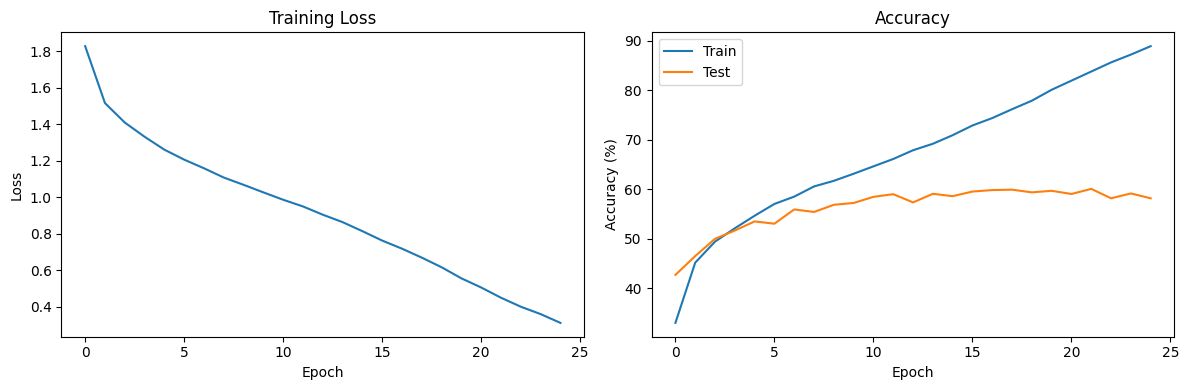

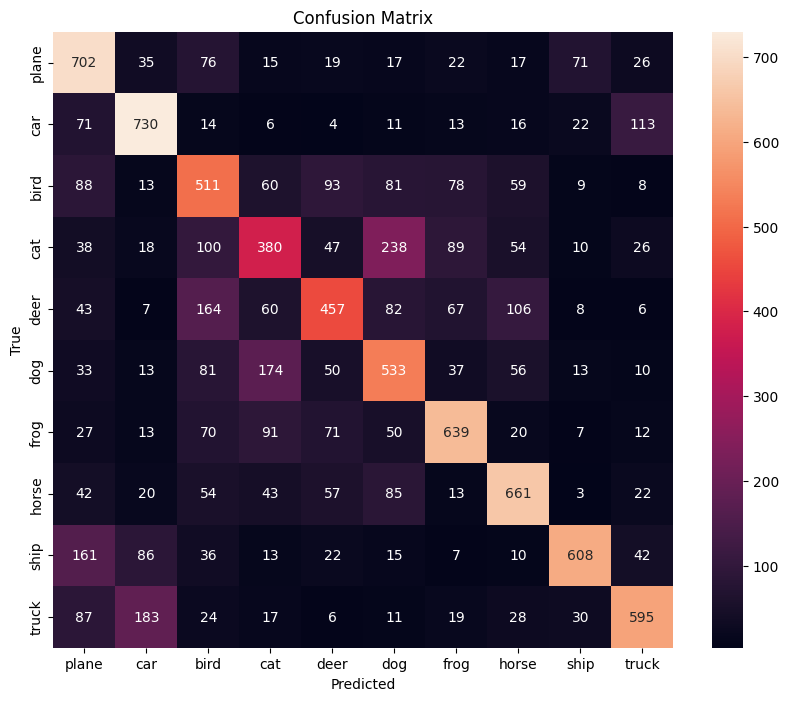

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].


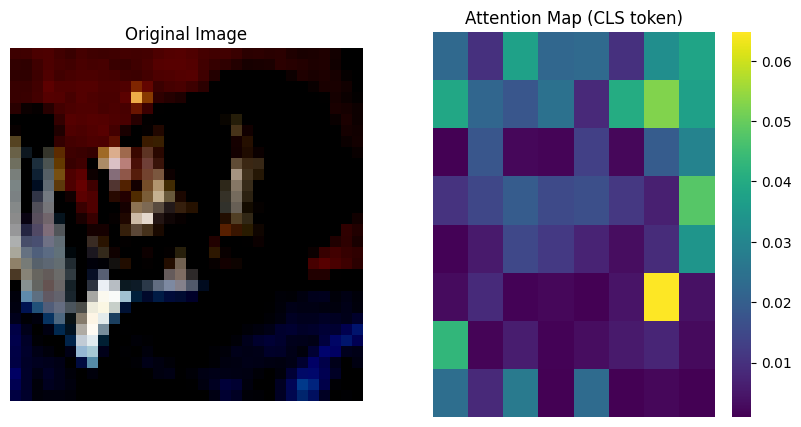

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# Vision Transformer Model Components
class PatchEmbedding(nn.Module):
    def __init__(self, image_size=32, patch_size=4, in_channels=3, embed_dim=192):
        super().__init__()
        self.patch_size = patch_size
        num_patches = (image_size // patch_size) ** 2
        self.projection = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)',
                     p1=patch_size, p2=patch_size),
            nn.Linear(patch_size * patch_size * in_channels, embed_dim)
        )
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.positions = nn.Parameter(torch.randn(num_patches + 1, embed_dim))

    def forward(self, x):
        b = x.shape[0]
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b=b)
        x = torch.cat([cls_tokens, x], dim=1)
        x = x + self.positions
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)
        
        self.attention_weights = None  # Store for visualization

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        self.attention_weights = attn.detach()  # Save for visualization

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        return x

class MLPBlock(nn.Module):
    def __init__(self, embed_dim, mlp_ratio=4):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * mlp_ratio),
            nn.GELU(),
            nn.Linear(embed_dim * mlp_ratio, embed_dim)
        )

    def forward(self, x):
        return self.mlp(x)

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(embed_dim, num_heads)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLPBlock(embed_dim)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class VisionTransformer(nn.Module):
    def __init__(self, image_size=32, patch_size=4, in_channels=3, 
                 num_classes=10, embed_dim=192, depth=12, num_heads=12):
        super().__init__()
        self.patch_embed = PatchEmbedding(image_size, patch_size, in_channels, embed_dim)
        self.transformer = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads) for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)
        for block in self.transformer:
            x = block(x)
        x = self.norm(x)
        x = x[:, 0]  # Use CLS token
        return self.head(x)

# Training and visualization functions
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    return total_loss / len(train_loader), accuracy

def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    accuracy = 100. * correct / total
    return accuracy, all_preds, all_labels

def visualize_attention(model, image, device):
    model.eval()
    with torch.no_grad():
        # Get attention weights from the last transformer block
        _ = model(image.unsqueeze(0).to(device))
        attn_weights = model.transformer[-1].attn.attention_weights
        
        # Average attention weights across heads
        attn_weights = attn_weights.mean(1)
        
        # Get attention from CLS token to patches
        cls_attn = attn_weights[0, 0, 1:].reshape(8, 8)  # Assuming 8x8 patches
        
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(image.permute(1, 2, 0))
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        sns.heatmap(cls_attn.cpu(), cmap='viridis')
        plt.title('Attention Map (CLS token)')
        plt.axis('off')
        plt.show()

def plot_training_history(train_losses, train_accs, test_accs):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train')
    plt.plot(test_accs, label='Test')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(true_labels, pred_labels, classes):
    cm = torch.zeros(len(classes), len(classes))
    for t, p in zip(true_labels, pred_labels):
        cm[t, p] += 1
        
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='.0f', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Main training loop
def main():
    # Setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Data loading
    transform = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                           download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                            shuffle=True, num_workers=2)
    
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                          download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                           shuffle=False, num_workers=2)
    
    classes = ('plane', 'car', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck')
    
    # Model initialization
    model = VisionTransformer().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.05)
    
    # Training
    num_epochs = 25
    train_losses = []
    train_accs = []
    test_accs = []
    
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, trainloader, criterion, optimizer, device)
        test_acc, _, _ = evaluate(model, testloader, device)
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Test Acc: {test_acc:.2f}%')
    
    # Final evaluation and visualization
    test_acc, all_preds, all_labels = evaluate(model, testloader, device)
    print(f'\nFinal Test Accuracy: {test_acc:.2f}%')
    
    # Plot training history
    plot_training_history(train_losses, train_accs, test_accs)
    
    # Plot confusion matrix
    plot_confusion_matrix(all_labels, all_preds, classes)
    
    # Visualize attention for a sample image
    sample_image, _ = next(iter(testloader))
    visualize_attention(model, sample_image[0], device)

if __name__ == '__main__':
    main()